# Experiments to test the LMPROJ method on synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from tensorlibrary.learning.transfer import CPKRR_LMPROJ, SVC_LMPROJ
from tensorlibrary.learning import CPKRR
from sklearn.svm import SVC
from krr import KRR_LMPROJ_Classifier, KRRClassifier

## Generate the data

Define a sampling function

In [2]:
def gauss_pos_vs_uniform_neg(
        centers_source,
        covs_source,
        centers_target=None,
        covs_target=None,
        n_samples=1000,
        full_box=[-1, 1],
        exclusion_radius=0.2,
):
    """
    Create domain adaptation dataset with:
    - Positive class: Gaussian mixtures (user-defined centers & covariances)
    - Negative class: Uniform over full_box excluding circles around centers
    - Domain shift via different centers/covs for target domain

    All labels are {-1, +1}
    """

    n_pos_components = len(centers_source)
    samples_per_component = n_samples // 2 // n_pos_components
    n_pos = samples_per_component * n_pos_components
    n_neg = n_samples - n_pos

    # === Source Positive Samples ===
    X_pos = []
    for i in range(n_pos_components):
        X_comp = np.random.multivariate_normal(
            mean=centers_source[i],
            cov=covs_source[i],
            size=samples_per_component
        )
        X_pos.append(X_comp)
    X_pos = np.vstack(X_pos)
    y_pos = np.ones(X_pos.shape[0], dtype=int)

    # === Source Negative Samples ===
    def sample_outside_circles(n, centers, radius, box):
        out = []
        while len(out) < n:
            pts = np.random.uniform(box[0], box[1], size=(n, 2))
            keep_mask = np.ones(n, dtype=bool)
            for c in centers:
                dists = np.linalg.norm(pts - c, axis=1)
                keep_mask &= dists > radius
            out.extend(pts[keep_mask])
        return np.array(out[:n])

    X_neg = sample_outside_circles(n_neg, centers_source, exclusion_radius, full_box)
    y_neg = -np.ones(X_neg.shape[0], dtype=int)

    X = np.vstack([X_pos, X_neg])
    y = np.concatenate([y_pos, y_neg])

    # === Target Positive Samples ===
    if centers_target is None:
        centers_target = centers_source
    if covs_target is None:
        covs_target = covs_source

    X_pos_target = []
    for i in range(n_pos_components):
        X_comp = np.random.multivariate_normal(
            mean=centers_target[i],
            cov=covs_target[i],
            size=samples_per_component
        )
        X_pos_target.append(X_comp)
    X_pos_target = np.vstack(X_pos_target)
    y_pos_target = np.ones(X_pos_target.shape[0], dtype=int)

    # === Target Negative Samples ===
    X_neg_target = sample_outside_circles(n_neg, centers_target, exclusion_radius, full_box)
    y_neg_target = -np.ones(X_neg_target.shape[0], dtype=int)

    X_target = np.vstack([X_pos_target, X_neg_target])
    y_target = np.concatenate([y_pos_target, y_neg_target])
    return X, y, X_target, y_target

Define a function to generate the centers and covariances

In [3]:
def generate_mean_cov(n_centers, domain=(-1,1), max_shift=0.3, base_cov=0.01):
    centers_source = []
    centers_target = []
    covs_source = []
    covs_target = []
    for i in range(n_centers):
        center = np.random.uniform(domain[0]+max_shift, domain[1]-max_shift, size=2)
        # check if center is too close to existing centers
        if i > 0:
            dists = np.array([np.linalg.norm(center - c) for c in centers_source])
            while (np.min(dists, axis=None) < 0.6):
                center = np.random.uniform(domain[0]+max_shift, domain[1]-max_shift, size=2)
                dists = np.array([np.linalg.norm(center - c) for c in centers_source])

        shift = np.random.uniform(-max_shift, max_shift, size=2)
        centers_source.append(center)
        centers_target.append(center + shift)
        covs_source.append(np.eye(2) * base_cov)
        covs_target.append(np.eye(2) * base_cov * np.random.uniform(0.5, 1.5, size=2))
    return centers_source, covs_source, centers_target, covs_target

In [4]:
def plot_domains(Xs, ys, Xt, yt, title="Domain Shift"):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Source")
    plt.scatter(Xs[:, 0], Xs[:, 1], c=ys, cmap='coolwarm', edgecolor='k')
    plt.subplot(1, 2, 2)
    plt.title("Target")
    plt.scatter(Xt[:, 0], Xt[:, 1], c=yt, cmap='coolwarm', edgecolor='k')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [5]:
# plot boundary function
def plot_decision_boundary(clf, X, y, title="Decision Boundary", xlim=None, ylim=None):
    # Define grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get decision boundary from classifier
    if hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(grid)[:,1]
    else:
        try:
            Z = clf.decision_function(grid)
        except AttributeError:  # no decision_function in adapt
            grid = clf.transform(grid)
            if hasattr(clf.estimator_, "predict_proba"):
                Z = clf.estimator_.predict_proba(grid)[:, 1]
            else:
                Z = clf.estimator_.decision_function(grid)

    Z = Z.reshape(xx.shape)

    if xlim is None:
        xlim = (X[:, 0].min(), X[:, 0].max())
    if ylim is None:
        ylim = (X[:, 1].min(), X[:, 1].max())

    # Plotting
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.6, levels=10, cmap='coolwarm')
    # plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title(title)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Generate the datasets

In [6]:
centers_s, covs_s, centers_t, covs_t = generate_mean_cov(n_centers=3)
X_s, y_s, X_t, y_t = gauss_pos_vs_uniform_neg(
    centers_source=centers_s,
    covs_source=covs_s,
    centers_target=centers_t,
    covs_target=covs_t,
    n_samples=1000,
    full_box=[-1, 1],
    exclusion_radius=0.25,
)

Visualize the datasets

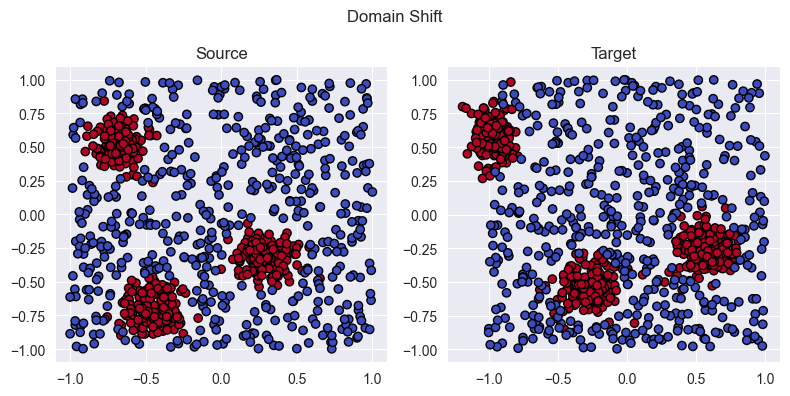

In [7]:
plot_domains(X_s, y_s, X_t, y_t)

## Train models

### Set hyperparameters

In [8]:
sig = 0.3
M = 15
Ld = 2.4
R = 10
reg_par = 1e-3
C = 10
RANDOM_STATE = 10
gam = 1/ (sig**2)

#### Source model

In [9]:
source = CPKRR(
    feature_map='rbf',
    M=M,
    map_param=sig,
    num_sweeps=10,
    reg_par=reg_par,
    max_rank=R,
    Ld=Ld,
    random_init=True,
    train_loss_flag=False,
    random_state=RANDOM_STATE,
)

In [10]:
# scaler = MinMaxScaler((-0.5,0.5))
# Xs = scaler.fit_transform(X_s)
# Xt = scaler.transform(Xt)
if np.min(y_t) == 0:
    y_t = 2*y_t -1
if np.min(y_s) == 0:
    y_s = 2*y_s -1

In [11]:
source.fit(X_s, y_s)

CPKRR(Ld=2.4, M=15, map_param=0.3, max_rank=10, num_sweeps=10, random_init=True,
      random_state=10, reg_par=0.001)

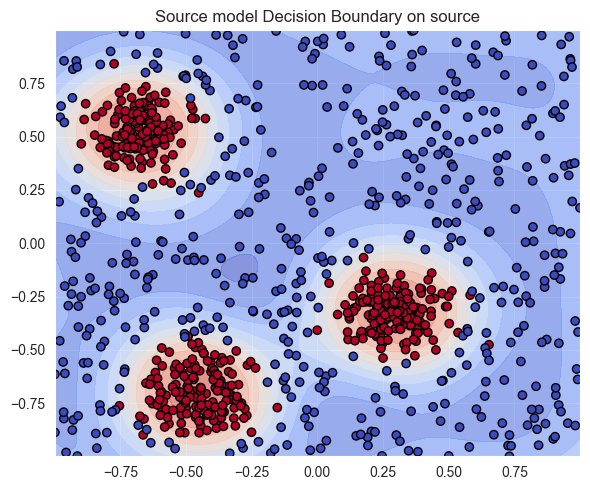

In [12]:
plot_decision_boundary(source, X_s, y_s, title="Source model Decision Boundary on source")

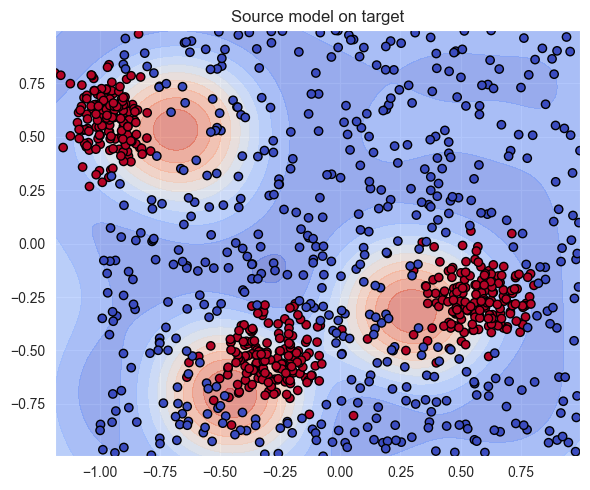

In [13]:
plot_decision_boundary(source, X_t, y_t, title="Source model on target")

SVC case

In [14]:
source_svc = SVC(
    C=C,
    kernel='rbf',
    gamma=gam,
)
source_svc.fit(X_s, y_s)

SVC(C=10, gamma=11.11111111111111)

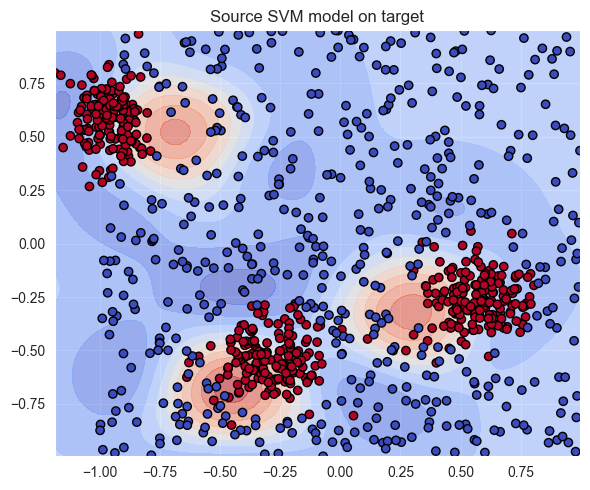

In [15]:
plot_decision_boundary(source_svc, X_t, y_t, title="Source SVM model on target")

#### LMPROJ model

In [16]:
adapt = CPKRR_LMPROJ(
        feature_map='rbf',
        M=M,
        map_param=sig,
        num_sweeps=10,
        reg_par=reg_par,
        max_rank=R,
        Ld=Ld,
        random_init=True,
        train_loss_flag=False,
        mu=(len(y_s)+len(y_t)),
        random_state=RANDOM_STATE,
    )

In [17]:
adapt.fit(X_s, y_s, x_target=X_t)

CPKRR_LMPROJ(Ld=2.4, M=15, map_param=0.3, max_rank=10, mu=2000, num_sweeps=10,
             random_state=10, reg_par=0.001)

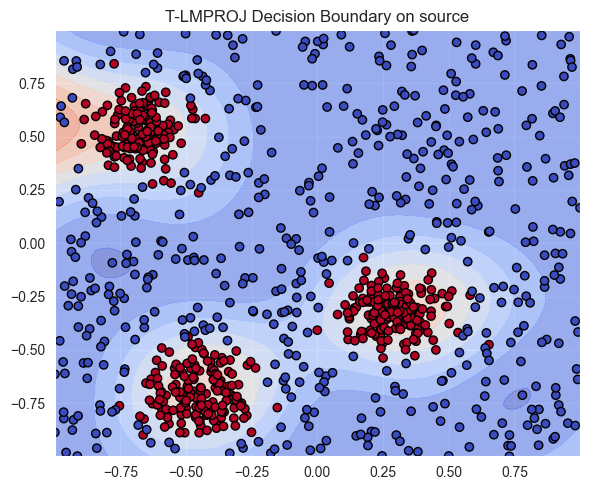

In [18]:
plot_decision_boundary(adapt, X_s, y_s, title="T-LMPROJ Decision Boundary on source")

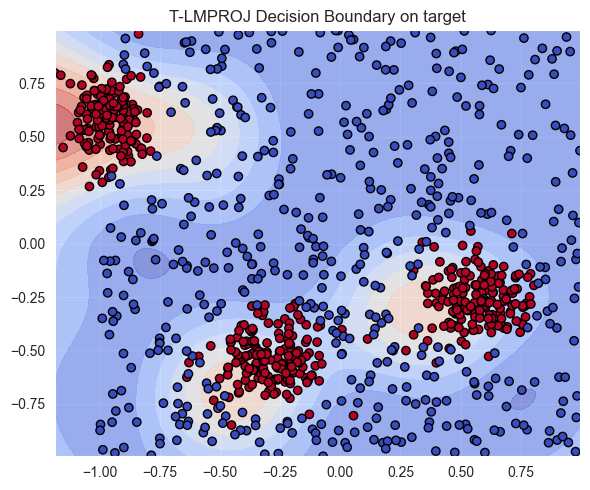

In [19]:
plot_decision_boundary(adapt, X_t, y_t, title="T-LMPROJ Decision Boundary on target")

SVM

In [33]:
adapt_KRR = KRR_LMPROJ_Classifier(
        kernel="rbf",
        reg_par=reg_par,
        gamma=gam,
        mu=(len(y_s)+len(y_t)),
)
adapt_KRR.fit(X_s, y_s, x_target=X_t)

KRR_LMPROJ_Classifier(gamma=11.11111111111111, mu=2000, reg_par=0.001)

In [35]:
adapt_SVM = SVC_LMPROJ(
        kernel='rbf',
        C = 0.1,
    mu=(len(y_s)+len(y_t)),
    gamma = gam,
    reg_par = reg_par,
    verbose=True
    )
adapt_SVM.fit(X_s, y_s, x_target=X_t)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 04 10:26:58 AM: Your problem has 3001 variables, 4004000 constraints, and 0 parameters.
(CVXPY) Dec 04 10:26:58 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 04 10:26:58 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 04 10:26:58 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 04 10:26:58 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 04 10:26:58 AM: Compiling problem (target solver=OSQ

SVC_LMPROJ(C=0.1, gamma=11.11111111111111, mu=2000, reg_par=0.001, verbose=True)

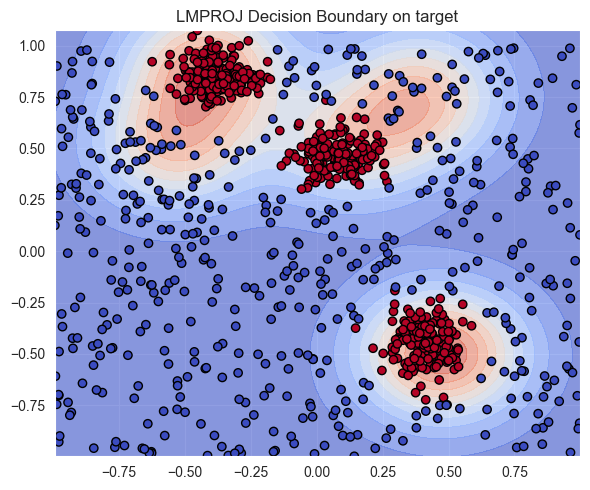

In [36]:
plot_decision_boundary(adapt_SVM, X_t, y_t, title="LMPROJ Decision Boundary on target")

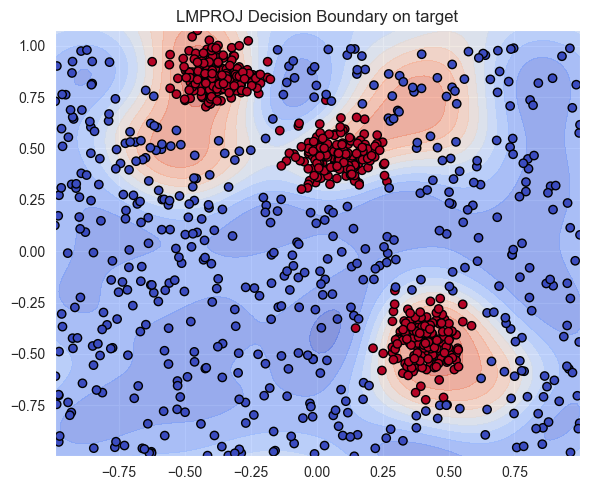

In [34]:
plot_decision_boundary(adapt_KRR, X_t, y_t, title="LMPROJ Decision Boundary on target")

## Multiple sims

In [42]:
n_iter = 10
acc_source = []
acc_adapt = []
acc_source_krr = []
acc_adapt_krr = []
acc_source_SVM = []
acc_adapt_SVM = []
SAVE=True
import pickle
for n in range(n_iter):
    centers_s, covs_s, centers_t, covs_t = generate_mean_cov(n_centers=3)
    X_s, y_s, X_t, y_t = gauss_pos_vs_uniform_neg(
        centers_source=centers_s,
        covs_source=covs_s,
        centers_target=centers_t,
        covs_target=covs_t,
        n_samples=1000,
        full_box=[-1, 1],
        exclusion_radius=0.25,
    )
    if SAVE:
        dataset = {"X_s": X_s, "y_s": y_s, "X_t": X_t, "y_t": y_t}
        with open(f"data/syn_data_{n}.pkl", "wb") as f:
            pickle.dump(dataset, f)


    source = CPKRR(
        feature_map='rbf',
        M=M,
        map_param=sig,
        num_sweeps=10,
        reg_par=reg_par,
        max_rank=R,
        Ld=Ld,
        random_init=True,
        train_loss_flag=False,
    )

    adapt = CPKRR_LMPROJ(
        feature_map='rbf',
        M=M,
        map_param=sig,
        num_sweeps=10,
        reg_par=reg_par,
        max_rank=R,
        Ld=Ld,
        random_init=True,
        train_loss_flag=False,
        mu=(len(y_s)+len(y_t)),
        random_state=RANDOM_STATE,
    )

    source_krr = KRRClassifier(
        kernel="rbf",
        reg_par=reg_par,
        gamma=gam,
    )

    adapt_krr = KRR_LMPROJ_Classifier(
        kernel="rbf",
        reg_par=reg_par,
        gamma=gam,
        mu=(len(y_s)+len(y_t)),
    )

    source_SVM = SVC(
        kernel='rbf',
        C=1.0,
        gamma=gam,
    )

    adapt_SVM = SVC_LMPROJ(
        kernel='rbf',
        C = 1.0,
    mu=(len(y_s)+len(y_t)),
    gamma = gam,
    reg_par = reg_par,
    verbose=False
    )

    
    source.fit(X_s, y_s)
    adapt.fit(X_s, y_s, x_target=X_t)

    source_krr.fit(X_s, y_s)
    adapt_krr.fit(X_s, y_s, x_target=X_t)

    source_SVM.fit(X_s, y_s)
    adapt_SVM.fit(X_s, y_s, x_target=X_t)

    y_source = source.predict(X_t)
    y_adapt = adapt.predict(X_t)

    y_source_krr = source_krr.predict(X_t)
    y_adapt_krr = adapt_krr.predict(X_t)

    y_source_SVM = source_SVM.predict(X_t)
    y_adapt_SVM = adapt_SVM.predict(X_t)

    acc_source.append(accuracy_score(y_t, y_source))
    acc_adapt.append(accuracy_score(y_t, y_adapt))
    acc_source_krr.append(accuracy_score(y_t, y_source_krr))
    acc_adapt_krr.append(accuracy_score(y_t, y_adapt_krr))
    acc_source_SVM.append(accuracy_score(y_t, y_source_SVM))
    acc_adapt_SVM.append(accuracy_score(y_t, y_adapt_SVM))



In [44]:
print(f"Source model Accuracy: {np.mean(acc_source)} ({np.std(acc_source)})")
print(f"LMPROJ model accuracy: {np.mean(acc_adapt)} ({np.std(acc_adapt)})")

Source model Accuracy: 0.7396999999999998 (0.09376251916410948)
LMPROJ model accuracy: 0.9098 (0.028627958362412095)


In [45]:
print(f"Source KRR model accuracy: {np.mean(acc_source_krr)} ({np.std(acc_source_krr)})")
print(f"LMPROJ KRR model accuracy: {np.mean(acc_adapt_krr)} ({np.std(acc_adapt_krr)}))")

Source KRR model accuracy: 0.7278 (0.09822402964651775)
LMPROJ KRR model accuracy: 0.8948 (0.02285519634568911))


In [46]:
print(f"Source SVM mdoel accuracy: {np.mean(acc_source_SVM)} ({np.std(acc_source_SVM)})")
print(f"LMPROJ SVM model accuracy: {np.mean(acc_adapt_SVM)} ({np.std(acc_adapt_SVM)}))")

Source SVM mdoel accuracy: 0.7239 (0.09492465433173827)
LMPROJ SVM model accuracy: 0.8839 (0.043175108569637674))
